# Gamma and Proton Classification with Deep Learning

In [1]:
%matplotlib inline

import torch.nn as nn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyarrow.parquet as pq
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

import pathlib
import gc

random_state = 420

gpu = torch.device("cuda:0")
cpu = torch.device("cpu")

In [2]:
data_path = pathlib.Path("../..")

#gammas = pd.read_parquet(data_path / "data" / "magic-gammas-new-1.parquet")[:20000]
#protons = pd.read_parquet(data_path / "data" / "magic-protons.parquet")[0:20000]

gammas = next(pq.ParquetFile(data_path / "data" / "magic-gammas-new-1.parquet").iter_batches(40000)).to_pandas()
protons = next(pq.ParquetFile(data_path / "data" / "magic-protons.parquet").iter_batches(40000)).to_pandas()

protons["class"] = 0
gammas["class"] = 1

protons = protons.dropna()
gammas = gammas.dropna()

dataset = pd.concat([gammas, protons])

In [3]:
FEATURE_SIZE = 67

X = dataset.iloc[:, 0:FEATURE_SIZE]
y = dataset.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=random_state, stratify=y)

y_test = torch.from_numpy(y_test.values).float().to(cpu)
y_train = torch.from_numpy(y_train.values).float().to(cpu)

X_train_image_m1 = torch.from_numpy(np.array(X_train["clean_image_m1"].tolist())).float().to(cpu)
X_test_image_m1 = torch.from_numpy(np.array(X_test["clean_image_m1"].tolist())).float().to(cpu)
X_train_image_m2 = torch.from_numpy(np.array(X_train["clean_image_m2"].tolist())).float().to(cpu)
X_test_image_m2 = torch.from_numpy(np.array(X_test["clean_image_m2"].tolist())).float().to(cpu)

hillas_params = [
    "hillas_length_m1",
    "hillas_width_m1",
    "hillas_delta_m1",
    "hillas_size_m1",
    "hillas_cog_x_m1",
    "hillas_cog_y_m1",
    "hillas_sin_delta_m1",
    "hillas_cos_delta_m1",
    "hillas_length_m2",
    "hillas_width_m2",
    "hillas_delta_m2",
    "hillas_size_m2",
    "hillas_cog_x_m2",
    "hillas_cog_y_m2",
    "hillas_sin_delta_m2",
    "hillas_cos_delta_m2"
]
stereo_params = [
    "stereo_direction_x",       
    "stereo_direction_y",       
    "stereo_zenith",            
    "stereo_azimuth",           
    "stereo_dec",               
    "stereo_ra",                
    "stereo_theta2",            
    "stereo_core_x",            
    "stereo_core_y",            
    "stereo_impact_m1",         
    "stereo_impact_m2",         
    "stereo_impact_azimuth_m1", 
    "stereo_impact_azimuth_m2", 
    "stereo_shower_max_height", 
    "stereo_xmax",              
    "stereo_cherenkov_radius",  
    "stereo_cherenkov_density", 
    "stereo_baseline_phi_m1",   
    "stereo_baseline_phi_m2",   
    "stereo_image_angle",   
    "stereo_cos_between_shower"
]

X_train_hillas = torch.from_numpy(X_train[hillas_params].values).float().to(cpu)
X_test_hillas = torch.from_numpy(X_test[hillas_params].values).float().to(cpu)

X_train_stereo = torch.from_numpy(X_train[stereo_params].values).float().to(cpu)
X_test_stereo = torch.from_numpy(X_test[stereo_params].values).float().to(cpu)

In [4]:
def combine(*features):
    return torch.cat((*features,), 1)

In [5]:
class MagicDataset(torch.utils.data.Dataset):
    def __init__(self, X_train, y_train):
        super(MagicDataset, self).__init__()

        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return self.y_train.shape[0]

    def __getitem__(self, index):
        return self.X_train[index], self.y_train[index]


In [6]:
magic_dataset = MagicDataset(combine(X_train_image_m1, X_train_image_m2), y_train)

In [7]:
network = nn.Sequential(
    nn.Linear(1183 * 2, 1039),
    nn.ReLU(),
    nn.Linear(1039, 512),
    nn.ReLU(),
    nn.Linear(512, 1),
    nn.Sigmoid()
).to(gpu)

network

Sequential(
  (0): Linear(in_features=2366, out_features=1039, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1039, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=1, bias=True)
  (5): Sigmoid()
)

In [8]:
loss = nn.BCELoss()

optimizer = torch.optim.SGD(network.parameters(), lr=0.001)

In [9]:
def train(model, loss, optimizer, epochs, X_train, y_train, X_test, y_test):
    loss_history = np.zeros(shape=epochs)
    accuracy_history = np.zeros(shape=epochs)
    test_loss_history = np.zeros(shape=epochs)
    test_accuracy_history = np.zeros(shape=epochs)
    dataset = MagicDataset(X_train, y_train)

    for epoch in range(epochs):
        magic_dataloader = DataLoader(magic_dataset, batch_size=64)

        for x, y in magic_dataloader:
            prediction = model(x.to(gpu))[:, 0]
        
            epoch_loss = loss(prediction.to(float), y.to(gpu).to(float))
            epoch_loss.backward()

            optimizer.step()
            optimizer.zero_grad()

            loss_history[epoch] = epoch_loss.item()
            class_predictions = ((prediction >= 0.5).float() == y.to(gpu)).float()
            accuracy_history[epoch] = class_predictions.mean()

        test_prediction = model(X_test.to(gpu))[:, 0]
        test_loss_history[epoch] = loss(test_prediction.to(float), y_test.to(gpu).to(float))
        test_class_predictions = ((test_prediction >= 0.5).float() == y_test.to(gpu)).float()
        test_accuracy_history[epoch] = test_class_predictions.mean()


        print(f"Finished epoch {epoch} of {epochs}")

    return (loss_history, accuracy_history, test_loss_history, test_accuracy_history)


In [10]:
loss, accuracy, test_loss, test_accuracy = train(network, loss, optimizer, 50, combine(X_train_image_m1, X_train_image_m2), y_train, combine(X_test_image_m1, X_test_image_m2), y_test)

Finished epoch 0 of 50
Finished epoch 1 of 50
Finished epoch 2 of 50
Finished epoch 3 of 50
Finished epoch 4 of 50
Finished epoch 5 of 50
Finished epoch 6 of 50
Finished epoch 7 of 50
Finished epoch 8 of 50
Finished epoch 9 of 50
Finished epoch 10 of 50
Finished epoch 11 of 50
Finished epoch 12 of 50
Finished epoch 13 of 50
Finished epoch 14 of 50
Finished epoch 15 of 50
Finished epoch 16 of 50
Finished epoch 17 of 50
Finished epoch 18 of 50
Finished epoch 19 of 50
Finished epoch 20 of 50
Finished epoch 21 of 50
Finished epoch 22 of 50
Finished epoch 23 of 50
Finished epoch 24 of 50
Finished epoch 25 of 50
Finished epoch 26 of 50
Finished epoch 27 of 50
Finished epoch 28 of 50
Finished epoch 29 of 50
Finished epoch 30 of 50
Finished epoch 31 of 50
Finished epoch 32 of 50
Finished epoch 33 of 50
Finished epoch 34 of 50
Finished epoch 35 of 50
Finished epoch 36 of 50
Finished epoch 37 of 50
Finished epoch 38 of 50
Finished epoch 39 of 50
Finished epoch 40 of 50
Finished epoch 41 of 50
Fi

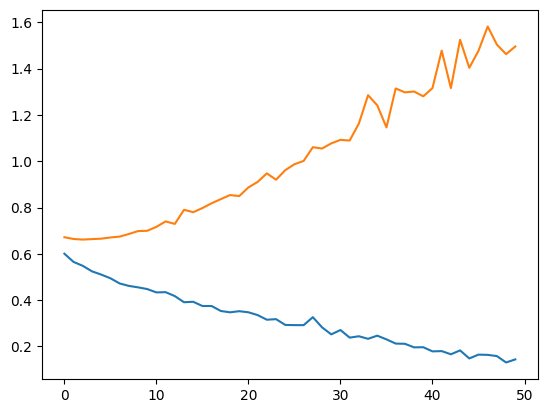

In [12]:
plt.plot(range(50), loss)
plt.plot(range(50), test_loss)

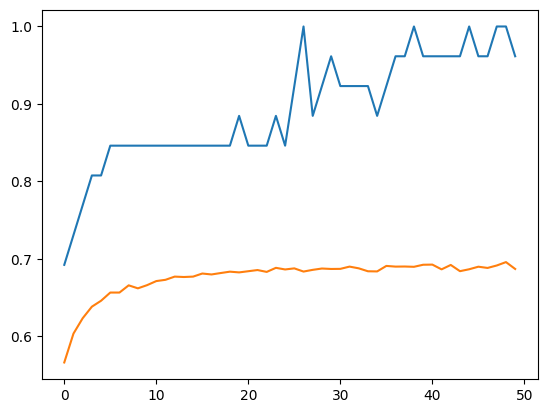

In [13]:
plt.plot(range(50), accuracy)
plt.plot(range(50), test_accuracy)